In [17]:
%pip install --user --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for extract_lfaa_pcap_info

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-k6crvmrc
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-k6crvmrc
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit c5694483129b908c703acabca090385a6250cc91
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ska-low-csp-test: filename=ska_low_csp_test-0.1.0-py3-none-any.whl size=61610 sha256=80a73a6fe08b5e5f6dc7b8206fa0dd265fee31a32827571a60e4341708bf911a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jd10kn7g/wheels/9a/4c/02/8c74169d793e4768d3530e96354bd6ad020d545a72797bdcac
Successfully built ska-low-csp-test
Note: you may need to restart the

In [18]:
import itertools
from functools import partial
from operator import attrgetter

import numpy as np
import matplotlib.pylab as plt

from ska_low_csp_test.pcap import PcapReader
from ska_low_csp_test.sps import SpsSpead

In [19]:
NUM_SAMPLES_PER_CHANNEL = 2048

def get_pcap_samples(pcap: PcapReader) -> np.ndarray:
    """Read samples from PCAP file.

    :param pcap: PCAP reader instance

    :returns: numpy matrix of the sample values
    """
    values = map(lambda packet: packet[SpsSpead].values, pcap)
    pols = map(partial(map, attrgetter("vPolReal", "vPolImag", "hPolReal", "hPolImag")), values)
    samples = map(partial(map, lambda t: np.array(t, dtype=((np.ubyte, 4)))), pols)
    flattened = itertools.chain.from_iterable(samples)
    array = np.fromiter(flattened, dtype=(((np.byte, 4))))
    matrix = np.reshape(array, (-1, NUM_SAMPLES_PER_CHANNEL, 4))
    return matrix

In [20]:
file_name = "/mnt/clp-k8s-fpga-worker-1/pcap/output/20240728_095805_noise_H_noise_V_itc_corr_1.sps.pcap"
file_name = "/mnt/clp-k8s-fpga-worker-1/pcap/output/20240728_132808_tone_H_tone_V_itc_corr_1.sps.pcap"
file_name = "/mnt/clp-k8s-fpga-worker-1/pcap/output/20240728_134333_noisytone_H_noisytone_V_itc_corr_1.sps.pcap"
file_name = "/mnt/clp-k8s-fpga-worker-1/pcap/output/20240728_135102_tone_H_noise_V_itc_corr_1.sps.pcap"
file_name = "/mnt/clp-k8s-fpga-worker-1/pcap/output/20240728_135742_twotones_H_noise_V_itc_corr_1.sps.pcap"

In [21]:
pcap = PcapReader(file_name)
samples = get_pcap_samples(pcap)
samples.shape

(1440, 2048, 4)

In [22]:
n_stations = 5
n_channels = 96
n_packets = int(samples.shape[0]/(n_stations*n_channels))

### Structure of SPS data

[NOF_PACKETS_PER_STATION][NOF_STATIONS][NOF_CHANNELS][2048 timesamples][Vreal, Vimag, Hreal, Himag]

In [23]:
sps=samples.reshape((n_packets, n_stations, n_channels, 2048, 4))
print(sps.shape)

(3, 5, 96, 2048, 4)


In [24]:
vr,vi,hr,hi=sps[:,:,:,:,0],sps[:,:,:,:,1],sps[:,:,:,:,2],sps[:,:,:,:,3]
channel_data = np.zeros((n_packets, n_stations, n_channels, 4))
print(channel_data.shape)
channel_data[:,:,:,0]=np.mean(vr,axis=-1)
channel_data[:,:,:,1]=np.mean(vi,axis=-1)
channel_data[:,:,:,2]=np.mean(hr,axis=-1)
channel_data[:,:,:,3]=np.mean(hi,axis=-1)

(3, 5, 96, 4)


In [25]:
# Convert real,imag dimensions into complex array
#     c_arr = arr[...,0] + arr[...,1] * 1j
v_channels = np.nanmean(channel_data[:, :, :, 0] + 1j * channel_data[:, :, :, 1], axis=0)
h_channels = np.nanmean(channel_data[:, :, :, 2] + 1j * channel_data[:, :, :, 3], axis=0)
print(v_channels.shape)
print(h_channels.shape)
channels = range(n_channels)

(5, 96)
(5, 96)


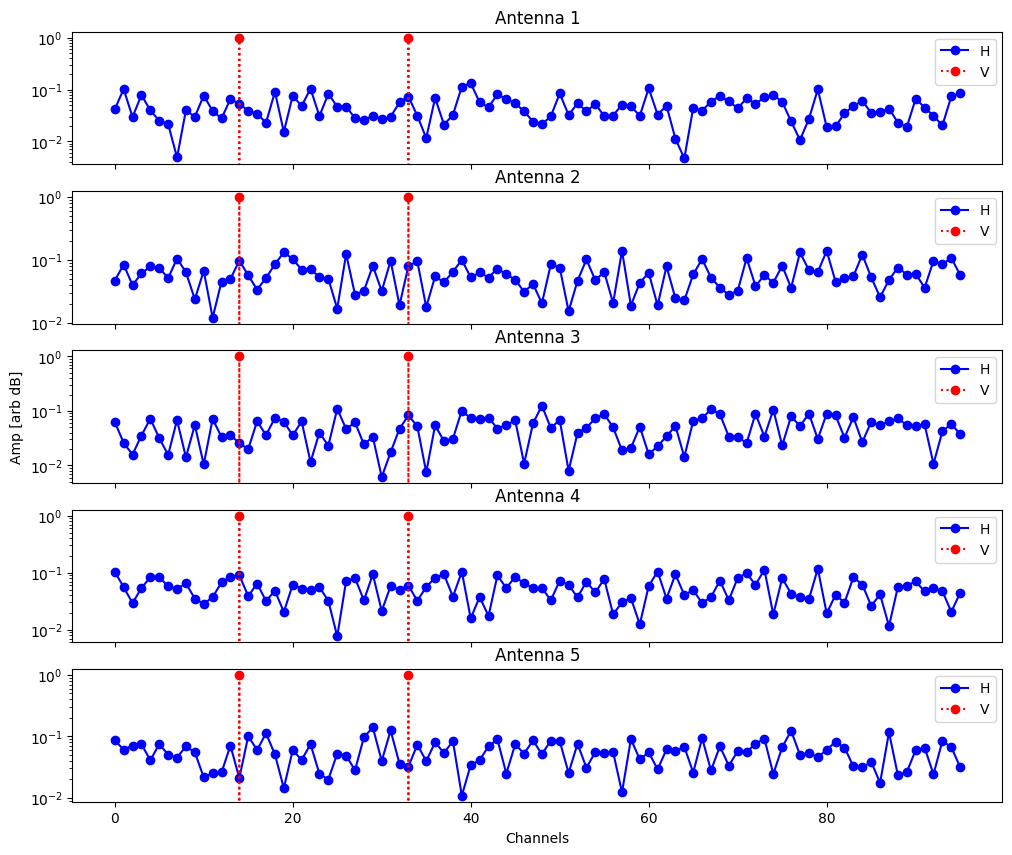

In [26]:
# plot amplitude-
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True)
for idx in range(n_stations):
    axes[idx].semilogy(channels, np.abs(h_channels[idx,:]), "bo-", label="H")
    axes[idx].semilogy(channels, np.abs(v_channels[idx,:]), "ro:", label="V")
    axes[idx].set_title(f"Antenna {idx+1}")
    axes[idx].legend()
    
axes[n_stations-1].set_xlabel("Channels")
axes[2].set_ylabel('Amp [arb dB]')
plt.show()

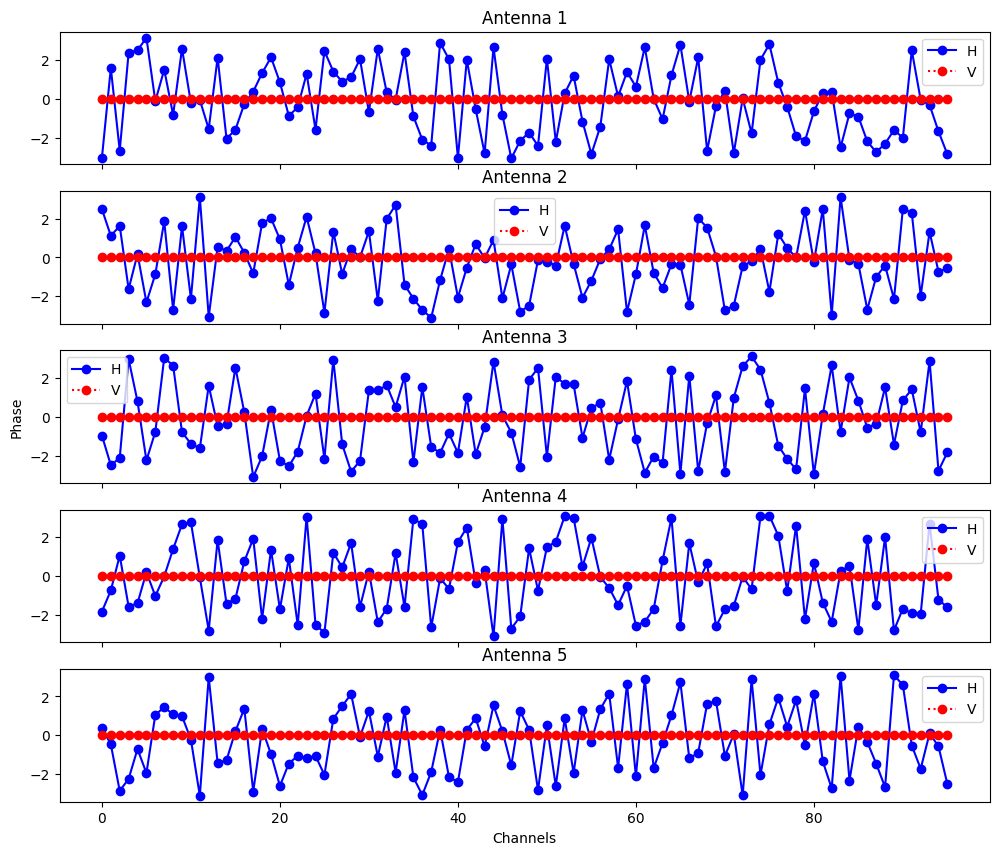

In [44]:
# plot phase-
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True)
for idx in range(n_stations):
    axes[idx].plot(channels, np.angle(h_channels[idx,:]), "bo-", label="H")
    axes[idx].plot(channels, np.angle(v_channels[idx,:]), "ro:", label="V")
    axes[idx].set_title(f"Antenna {idx+1}")
    axes[idx].legend()
    
axes[n_stations-1].set_xlabel("Channels")
axes[2].set_ylabel('Phase')

plt.show()